In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [274]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    if 'total' in dfXY.columns:
        dfXY.drop('total', axis=1, inplace=True)
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

In [332]:
pklfile = '../learn/pkl_trainsets/28jun2019/_nucs_fissact_not-scaled.pkl'
trainXY = pd.read_pickle(pklfile)
trainXY.reset_index(inplace=True, drop=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
isos = ['ba138', 'cs133', 'cs137', 'cs135', 'pu239', 'pu240', 'pu241', 'pu242']
trainXY = trainXY[isos+lbls]
trainXY = trainXY.sample(frac=0.3)
X, rY, cY, eY, bY, oY = splitXY(trainXY)
#X = scale(X)

In [333]:
trainXY.head(10)

,ba138,cs133,cs137,cs135,pu239,pu240,pu241,pu242,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
481,10.840,9.597,10.290,0.000,15.210,5.265,5.685,4.07000,pwr,0.556142,2.18,38197.00,ce14x14
8174,2.715,2.604,2.555,0.000,13.650,2.324,1.198,0.10800,pwr,0.525010,3.07,9225.82,bw15x15
8217,6.223,5.864,5.915,0.000,17.790,4.638,4.786,1.25300,pwr,0.000000,3.07,21611.49,bw15x15
11627,7.232,6.780,6.741,0.000,12.250,4.794,3.387,1.49400,bwr,0.000680,1.49,24850.40,ge8x8-1
21922,11.990,10.410,11.190,0.000,13.270,5.352,4.629,4.86900,bwr,1.293946,1.39,42355.23,svea100-0
9839,3.120,3.008,2.881,0.000,8.336,1.987,0.000,0.06713,bwr,0.573874,0.50,10388.57,ge7x7-0
22779,3.158,3.052,2.975,1.031,15.700,2.801,1.728,0.00000,bwr,0.000514,5.17,10825.83,svea100-0
20361,4.192,4.095,3.886,0.000,11.230,3.109,0.000,0.25460,bwr,28.263604,1.44,14134.53,svea64-1
5773,15.770,12.640,14.970,0.000,13.580,5.509,5.184,7.33100,pwr,0.000000,1.49,56689.24,s14x14
11222,16.620,13.020,15.470,0.000,17.660,5.015,6.656,0.00000,bwr,0.749299,4.58,60223.71,ge7x7-0


# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [335]:
test_sample = X.loc[trainXY.index == 23608]
test_answer = trainXY.loc[trainXY.index == 23608, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]
test_answer
#est_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
23608,pwr,2405.758328,3.82,36551.59,vver440_3.82


In [336]:
def ll_calc(y_sim, y_mes):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes))
    return ll

def unc_calc(y_sim, y_mes, sim_unc, mes_unc):
    sim_unc = sim_unc * y_sim
    mes_unc = mes_unc * y_mes
    unc = ((y_sim - y_mes) / sim_unc**2)**2 * (sim_unc**2 + mes_unc**2)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [337]:
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample), axis=1)
row_unc = 0.14
test_unc = 0.14
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample, row_unc, test_unc), axis=1)
trainXY

,ba138,cs133,cs137,cs135,pu239,pu240,pu241,pu242,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,LogLikelihood,LLUncertainty
481,10.8400,9.5970,10.2900,0.0000,15.210,5.2650,5.68500,4.070000,pwr,0.556142,2.180,38197.00,ce14x14,-31.439652,5.813214e+00
8174,2.7150,2.6040,2.5550,0.0000,13.650,2.3240,1.19800,0.108000,pwr,0.525010,3.070,9225.82,bw15x15,-132.743229,9.137285e+03
8217,6.2230,5.8640,5.9150,0.0000,17.790,4.6380,4.78600,1.253000,pwr,0.000000,3.070,21611.49,bw15x15,-37.440199,5.167056e+01
11627,7.2320,6.7800,6.7410,0.0000,12.250,4.7940,3.38700,1.494000,bwr,0.000680,1.490,24850.40,ge8x8-1,-68.965675,3.679240e+01
21922,11.9900,10.4100,11.1900,0.0000,13.270,5.3520,4.62900,4.869000,bwr,1.293946,1.390,42355.23,svea100-0,-51.327532,9.988599e+00
9839,3.1200,3.0080,2.8810,0.0000,8.336,1.9870,0.00000,0.067130,bwr,0.573874,0.500,10388.57,ge7x7-0,-190.612149,2.389363e+04
22779,3.1580,3.0520,2.9750,1.0310,15.700,2.8010,1.72800,0.000000,bwr,0.000514,5.170,10825.83,svea100-0,-106.658517,1.034521e+02
20361,4.1920,4.0950,3.8860,0.0000,11.230,3.1090,0.00000,0.254600,bwr,28.263604,1.440,14134.53,svea64-1,-133.102669,1.583929e+03
5773,15.7700,12.6400,14.9700,0.0000,13.580,5.5090,5.18400,7.331000,pwr,0.000000,1.490,56689.24,s14x14,-89.735260,1.055233e+01
11222,16.6200,13.0200,15.4700,0.0000,17.660,5.0150,6.65600,0.000000,bwr,0.749299,4.580,60223.71,ge7x7-0,-76.219821,6.389076e+00


### Global Max LL

In [338]:
max_ll = trainXY['LogLikelihood'].max()
idx_ll = trainXY['LogLikelihood'].idxmax()
unc = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_ll])
print(f'Max Log Likelihood: {max_ll} +/- {unc}')

Max Log Likelihood: -7.351508265637381 +/- 0.0


In [339]:
trainXY.loc[trainXY.index == idx_ll, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
23608,pwr,2405.758328,3.82,36551.59,vver440_3.82


### Reactor-dependent Max LL (paper presents it this way)

#### PWR

In [340]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: -7.351508265637381 +/- 0.0


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
23608,pwr,2405.758328,3.82,36551.59,vver440_3.82


#### BWR

In [341]:
max_bwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'bwr'].max()
idx_bwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'bwr'].idxmax()
unc = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_bwr])
print(f'Max Log Likelihood for BWRs: {max_bwr} +/- {unc}')
trainXY.loc[trainXY.index == idx_bwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for BWRs: -14.016309265637382 +/- 2.7153406145075127


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
22637,bwr,7.740557,4.21,36094.91,svea100-0


#### PHWR

In [342]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: -180.43794876563737 +/- 71.49356432846002


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
24284,phwr,6.974108,0.711,13125.44,candu19


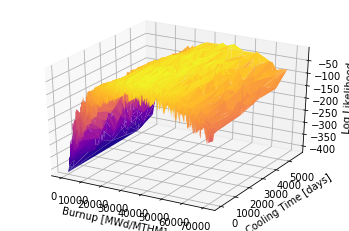

In [343]:
x = trainXY['Burnup']
y = trainXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = trainXY['LogLikelihood']

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap=plt.cm.plasma)
ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [36]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)

In [39]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [40]:
X.shape

(12398, 48)

In [41]:
mod = NormMod(y, X)

In [42]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 267306.240103
         Iterations: 36198
         Function evaluations: 41431
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -3.3141e+09
Model:                        NormMod   AIC:                         6.628e+09
Method:            Maximum Likelihood   BIC:                         6.628e+09
Date:                Wed, 14 Aug 2019                                         
Time:                        14:43:16                                         
No. Observations:               12398                                         
Df Residuals:                   12350                                         
Df Model:                          47                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
